Matthew Twete


Small experiment to finetune pretrained Resnet50 and VGG19 models on MNIST classification using only small amounts of data for training. The results were plotting as well.

Note some code taken/inspired from: https://androidkt.com/calculate-total-loss-and-accuracy-at-every-epoch-and-plot-using-matplotlib-in-pytorch/ and other sources

In [ ]:
#Import libraries
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from copy import deepcopy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data resizing and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.1307,0.1307,0.1307], [0.3081,0.3081,0.3081])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.1307,0.1307,0.1307], [0.3081,0.3081,0.3081])
    ]),
}

#Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transforms['val'],
)
#Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transforms['train'],
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
#Create class for custom datasets
class New_Dataset(Dataset):
    def __init__(self, data, label):
        self.x = data
        self.y = label

    def __getitem__(self, index):
        data = self.x[index]
        target = self.y[index]

        return data, target

    def __len__(self):
        return len(self.x)

In [ ]:
#Function to create dataset of a specific size, where size is the number of examples per class to be included
def create_dataset(train_set, test_set, batchsize, size):
  data_idx = 0
  target_idx = 1

  #Counter to keep track of number of each type of image collected
  counts = np.zeros(10)
  images = []
  labels = []
  total = size*10

  #Loop over data until the right number of each class are gathered
  for data in train_set:
    target = data[target_idx]
    if counts[target] <= size:
      images.append(deepcopy(data[data_idx]))
      labels.append(deepcopy(target))
      counts[target] += 1
    if sum(counts) >= total:
      break
  
  #Create the dataset and dataloaders & return dataloaders
  size_dataset = New_Dataset(images,labels)
  trainloader = torch.utils.data.DataLoader(size_dataset, batch_size=batchsize, shuffle=True)
  testloader = torch.utils.data.DataLoader(test_set, batch_size=batchsize, shuffle=True)
  return trainloader,testloader



In [ ]:
#Function to train the model, running the test data through the model after each epoch, keeps track of the best test accuracy achieved and 
#the epoch it was achieved at, returning those values at the end
def train_model(model, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25,):
    criterion = nn.CrossEntropyLoss()
    best_acc = 0.0
    best_epoch = -1
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Update the best test accuracy if there is an improvment and note the epoch 
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_acc_epoch = epoch + 1
                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    #return the best accuracy on test set achieved & the epoch it was achieved at
    return best_acc.item(), best_acc_epoch

In [ ]:
#Function to load a resnet50 model and update the final fully connected layer for 
#MNIST classification, freezing all other layer weights
def load_resnet_model():
  model_conv = torchvision.models.resnet50(pretrained=True)
  for param in model_conv.parameters():
    param.requires_grad = False
  num_ftrs = model_conv.fc.in_features
  model_conv.fc = nn.Linear(num_ftrs, 10)
  model_conv = model_conv.to(device)
  return model_conv


In [ ]:
#Function to load a VGG19 model and update the final fully connected layer for 
#MNIST classification, freezing all other layer weights
def load_vgg_model():
  model_conv = torchvision.models.vgg19(pretrained=True)
  for param in model_conv.parameters():
    param.requires_grad = False
  num_ftrs = model_conv.classifier[6].in_features
  model_conv.classifier[6] = nn.Linear(num_ftrs, 10)
  model_conv = model_conv.to(device)
  return model_conv


In [ ]:
#Dataset sizes
sizes = np.arange(10,110,20)

#Arrays to hold best test accuracies/epochs 
resnet_test_errors = []
vgg_test_errors = []
#Number of epochs to run the vgg and resnet models for
nEpoch1 = 20
nEpoch2 = 30
batch_size = 100

#Loop over each training set size 
for size in sizes:
  #Get dataloaders and put them & their sizes in dictionaries for the train function
  trainloader,testloader = create_dataset(training_data,test_data,batch_size,size)
  dataloaders = {'train': trainloader, 'val': testloader}
  dataset_sizes = {'train': len(trainloader.dataset), 'val': len(testloader.dataset)}

  #load models
  vgg = load_vgg_model()
  resnet = load_resnet_model()
  vgg_optimizer = optim.SGD(vgg.classifier[6].parameters(), lr=0.01, momentum=0.9)
  # Decay LR by a factor of 0.1 every 15 epochs
  vgg_exp_lr_scheduler = lr_scheduler.StepLR(vgg_optimizer, step_size=15, gamma=0.1)
  
  #Train the vgg model
  acc, epoch = train_model(vgg,vgg_optimizer,vgg_exp_lr_scheduler,dataloaders,dataset_sizes,nEpoch1)
  #Save the best test accuracy and epoch
  vgg_test_errors.append((acc,epoch))
  print("For size: ", size, "Best vgg test acc & epoch are: ", acc, "%  at epoch ", epoch)
  
  
  resnet_optimizer = optim.SGD(resnet.fc.parameters(), lr=0.05, momentum=0.9)
  # Decay LR by a factor of 0.1 every 10 epochs
  resnet_exp_lr_scheduler = lr_scheduler.StepLR(resnet_optimizer, step_size=10, gamma=0.1)
  #Train the resnet model
  acc, epoch = train_model(resnet,resnet_optimizer,resnet_exp_lr_scheduler,dataloaders,dataset_sizes,nEpoch2)
  #Save the best test accuracy and epoch
  resnet_test_errors.append((acc,epoch))
  print("For size: ", size, "Best resnet test acc & epoch are: ", acc, "%  at epoch ", epoch)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 0/19
----------
train Loss: 2.3417 Acc: 0.0800
val Loss: 2.1851 Acc: 0.2874

Epoch 1/19
----------
train Loss: 2.1817 Acc: 0.1900
val Loss: 2.0934 Acc: 0.2744

Epoch 2/19
----------
train Loss: 1.9906 Acc: 0.3400
val Loss: 1.9460 Acc: 0.4104

Epoch 3/19
----------
train Loss: 1.8096 Acc: 0.3700
val Loss: 1.7631 Acc: 0.5244

Epoch 4/19
----------
train Loss: 1.5865 Acc: 0.6000
val Loss: 1.6057 Acc: 0.5329

Epoch 5/19
----------
train Loss: 1.3878 Acc: 0.6100
val Loss: 1.4619 Acc: 0.6016

Epoch 6/19
----------
train Loss: 1.2106 Acc: 0.6900
val Loss: 1.3463 Acc: 0.6389

Epoch 7/19
----------
train Loss: 1.0244 Acc: 0.8300
val Loss: 1.2710 Acc: 0.6364

Epoch 8/19
----------
train Loss: 0.9061 Acc: 0.8100
val Loss: 1.2110 Acc: 0.6367

Epoch 9/19
----------
train Loss: 0.8427 Acc: 0.7800
val Loss: 1.1608 Acc: 0.6438

Epoch 10/19
----------
train Loss: 0.7356 Acc: 0.8100
val Loss: 1.1101 Acc: 0.6651

Epoch 11/19
----------
train Loss: 0.6656 Acc: 0.8500
val Loss: 1.0885 Acc: 0.6696

Ep

In [ ]:
#Separate out the best test accuracy values and the epoch their were achieved at for each model
resnet_acc = []
resnet_epochs = []
vgg_acc = []
vgg_epochs = []
def separate(original, acc, epoch):
  for data in original:
    acc.append(data[0])
    epoch.append(data[1])
  return acc, epoch
resnet_acc, resnet_epochs = separate(resnet_test_errors,resnet_acc, resnet_epochs)
vgg_acc, vgg_epochs = separate(vgg_test_errors,vgg_acc, vgg_epochs)

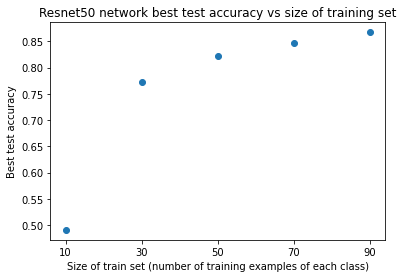

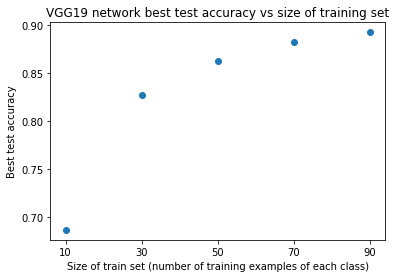

In [ ]:
#Function to plot the best test accuracy vs training set size
def plot_part1(test_acc, model_name, sizes):
    plt.title(model_name + ' network best test accuracy vs size of training set')
    plt.ylabel('Best test accuracy')
    plt.xlabel('Size of train set (number of training examples of each class)')
    plt.plot(sizes,test_acc,'o')
    plt.xticks(sizes)
    plt.show()
plot_part1(resnet_acc, 'Resnet50',sizes)
plot_part1(vgg_acc, 'VGG19',sizes)